In [1]:
#lines for google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz
import os
import datetime
import numpy as np
import torch as th
from torch_geometric.loader import DenseDataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pyg_classifier.data import CGDataset
from pyg_classifier.model import Diff_CG_Classifier, MinCut_CG_Classifier, DMoN_CG_Classifier
from pyg_classifier.train import pool_train_loop
from pyg_classifier.test import pool_test_loop

print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = True
k = 0

#Training Set
import torch_geometric.transforms as T
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt" #"data/train_rmsd_list.txt" #
training_dataset = CGDataset(training_dir, rmsd_list, vectorize, k, transform=T.ToDense(64))

#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"
val_dataset = CGDataset(val_dir, val_rmsd, vectorize, k, transform=T.ToDense(64))

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"
test_dataset = CGDataset(test_dir, test_rmsd, vectorize, k, transform=T.ToDense(64))

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"
st_test_dataset = CGDataset(st_test_dir, st_test_rmsd, vectorize, k, transform=T.ToDense(64))

#Rotated Test Sets
test_dir_rot = "data/test_set_rot"
test_rmsd = "data/test_rmsd_list.txt"
rot_test_dataset = CGDataset(test_dir_rot, test_rmsd, vectorize, k, transform=T.ToDense(64))

fst_test_rot = "data/5st_test_rot"
fst_rot_dataset = CGDataset(fst_test_rot, st_test_rmsd, vectorize, k, transform=T.ToDense(64))

Pytorch Version 1.11.0
Cuda is available: True
Using device: cuda


TODO:
*  **Check why fewer graphs are loaded into the training dataset than are in the rmsd list**
*  Change data preparation so that s0 is always at [0, 0, 1, 0, y_e, 1] **DONE**
*  Add further that start of s1 is in xy-plane with s0
*  Use A-Minor Interactions as an additional edge for graph construction **DONE**
*  are there additional tertiary interactions detected to add?
*  Integrate (Root) Mean Squared Error, Mean Absolute Error or other Regression Related Metric **DONE** 
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  add link prediction loss and entropy regularization to the loss function **DONE**
*  which noramlization to use?

Epoch 0: Training loss 12.4008, Validation loss 13.6843, learning rate 0.00100
		eadd_loss = -0.7439 vadd_loss = -0.7643
		Validation MAE: 14.9333
Epoch 5: Training loss 3.7650, Validation loss 15.1159, learning rate 0.00100
		eadd_loss = -0.7314 vadd_loss = -0.7203
		Validation MAE: 16.3288
Epoch 10: Training loss 2.4575, Validation loss 13.9811, learning rate 0.00100
		eadd_loss = -0.7592 vadd_loss = -0.7618
		Validation MAE: 15.2318
Epoch 15: Training loss 2.4226, Validation loss 13.5450, learning rate 0.00100
		eadd_loss = -0.6768 vadd_loss = -0.6809
		Validation MAE: 14.7071
Epoch 20: Training loss 1.5881, Validation loss 13.8545, learning rate 0.00100
		eadd_loss = -0.5776 vadd_loss = -0.6260
		Validation MAE: 14.9154
Epoch 25: Training loss 1.3595, Validation loss 13.8316, learning rate 0.00100
		eadd_loss = -0.5475 vadd_loss = -0.6201
		Validation MAE: 14.8700
Epoch 30: Training loss 0.9849, Validation loss 13.8861, learning rate 0.00100
		eadd_loss = -0.4947 vadd_loss = -0.588

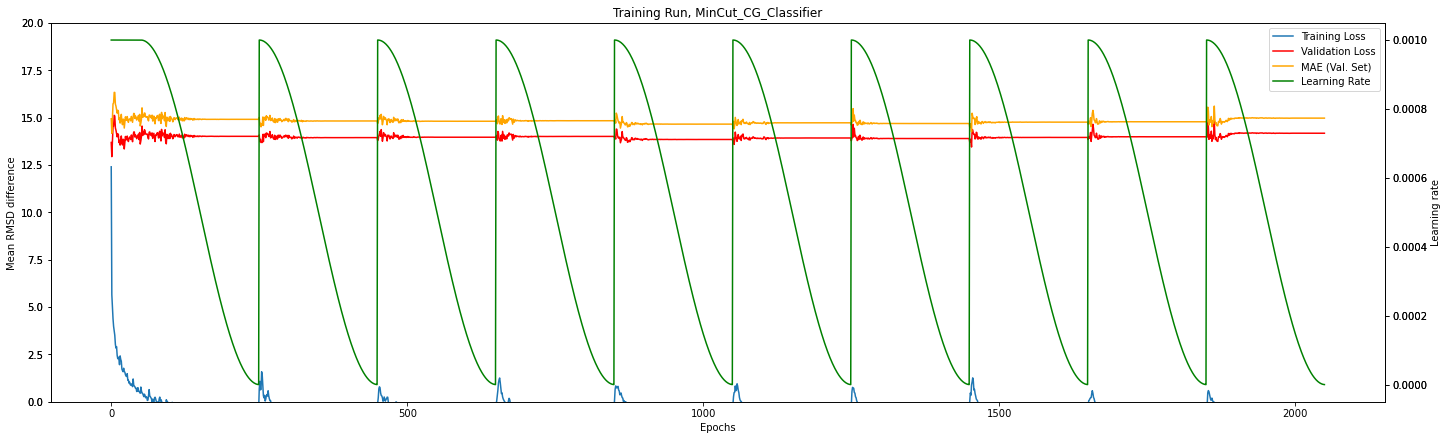

In [2]:
#Training
model = MinCut_CG_Classifier(training_dataset.num_node_features)

parent_dir = "pyg_model_data/"


#epoch_losses, val_losses, mae_losses, learning_rates, epoch_add_losses = 
pool_train_loop(
    model=model,
    train_dataset=training_dataset,
    val_dataset=val_dataset,
    model_dir=parent_dir,
    device=device,
    b_size=64,
    lr=1e-3,
    epochs=2000,
    sched_T0=200,
    vectorize=vectorize,
    k=k,
    burn_in=50)

In [3]:
#get training run data

run_dir = "pyg_model_data/2022-05-03_16-43_MinCut_CG_Classifier"

file_lines = []
with open(run_dir + "/loss_data.txt", "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]
epoch_add_losses = [float(d) for d in file_lines[4]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after 50 epochs) {min(val_losses[50:]):.4f} in epoch {val_losses.index(min(val_losses[50:]))}")
print(f"Minimum MAE (after 50 epochs) {min(mae_losses[50:]):.4f} in epoch {mae_losses.index(min(mae_losses[50:]))}")


Minimum Training Loss -0.3824 in epoch 166
Minimum Validation Loss (after 50 epochs) 13.4438 in epoch 1453
Minimum MAE (after 50 epochs) 14.2500 in epoch 1453


Validation Loss at 872 is 13.6947
5 before select
13.8508, 13.8077, 13.7931, 13.9395, 13.8978
5 after select
13.7359, 13.7329, 13.8081, 13.7278, 13.8021
MAE at 872 is 14.5098


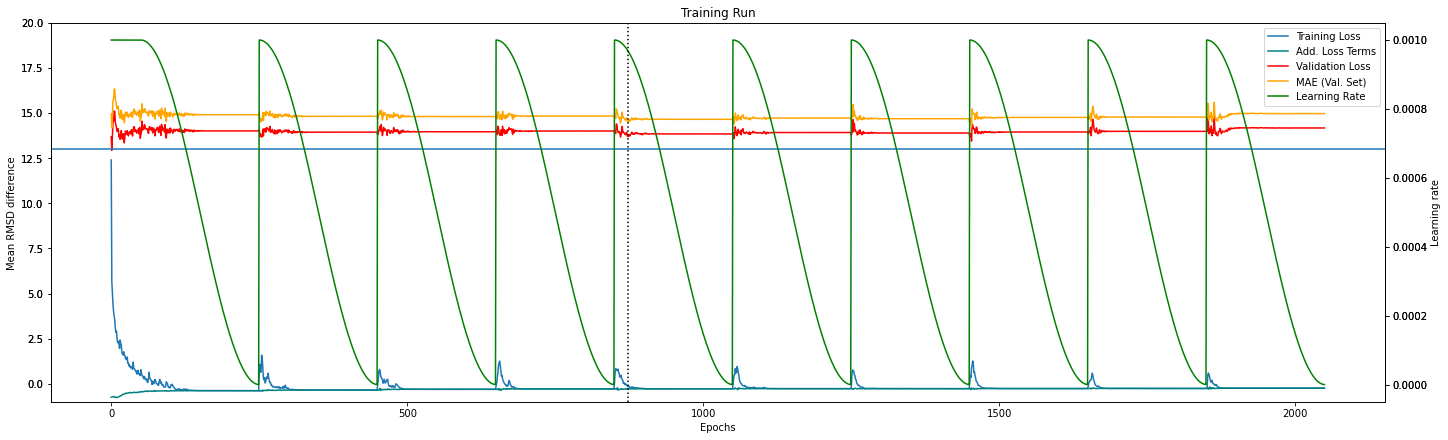

In [9]:
#plot the training run
select = 872
print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print((", ").join([f"{x:.4f}" for x in val_losses[select-5:select]]))
print("5 after select")
print((", ").join([f"{y:.4f}" for y in val_losses[select+1:select+6]]))
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(layout="constrained", figsize=(20, 6))
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(epoch_add_losses, "teal", label="Add. Loss Terms")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")
ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean RMSD difference")
ax2.set_ylabel("Learning rate")
ax1.set_ybound(lower=-1, upper=20)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=13)
han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2, loc="upper right")
plt.draw()

Test Set
tensor([[19.3690]], device='cuda:0') tensor([[19.1925]], device='cuda:0') 0.015570122748613358
tensor([[29.9810]], device='cuda:0') tensor([[2.2744]], device='cuda:0') 27.206560134887695
Mean Test loss: 	 11.2700
Std. Dev. of Test loss:  6.4716
Min loss: 		 0.0156
First Quantile: 	 6.4576
Median: 		 10.3780
Third Quantile: 	 16.9359
Max Loss: 		 27.2066
LinregressResult(slope=-0.09968458569850389, intercept=18.608574171084182, rvalue=-0.03241598248461666, pvalue=0.5911218736478986, stderr=0.18534214073352745, intercept_stderr=3.4212357296853955)


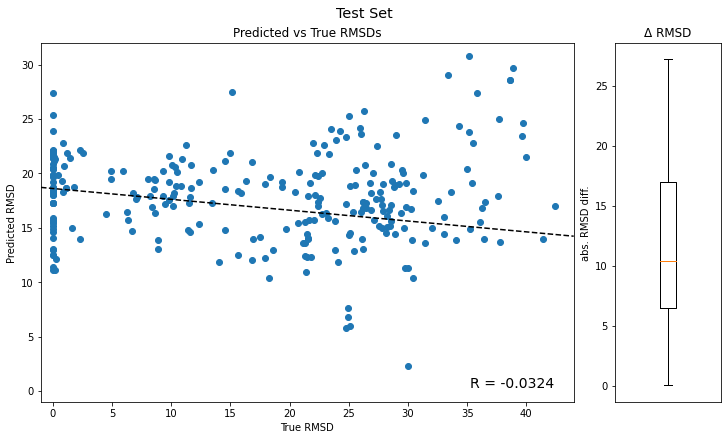

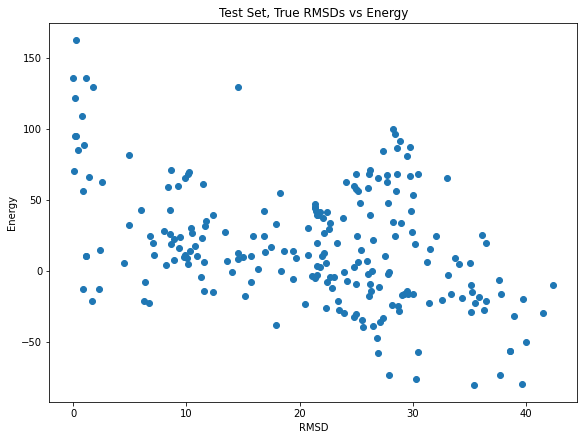

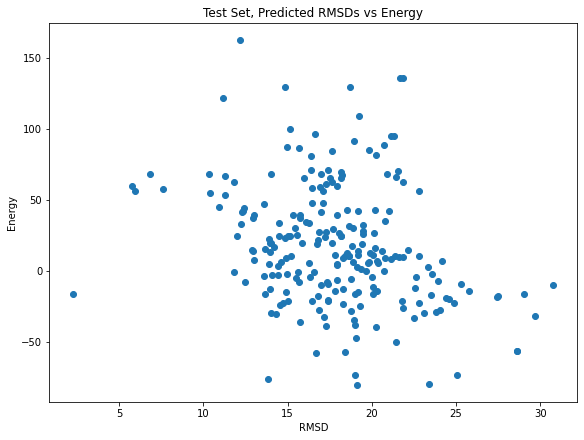

5S and tRNA Test Set
tensor([[12.8990]], device='cuda:0') tensor([[12.8988]], device='cuda:0') 2.6631823857314885e-08
tensor([[0.]], device='cuda:0') tensor([[25.4048]], device='cuda:0') 24.904829025268555
Mean Test loss: 	 3.7828
Std. Dev. of Test loss:  4.1225
Min loss: 		 0.0000
First Quantile: 	 0.9125
Median: 		 2.5276
Third Quantile: 	 5.0606
Max Loss: 		 24.9048
LinregressResult(slope=1.0045177178851923, intercept=-1.2912940150410197, rvalue=0.7582923614277266, pvalue=4.415459891227305e-203, stderr=0.02626629427408053, intercept_stderr=0.48294523474694645)


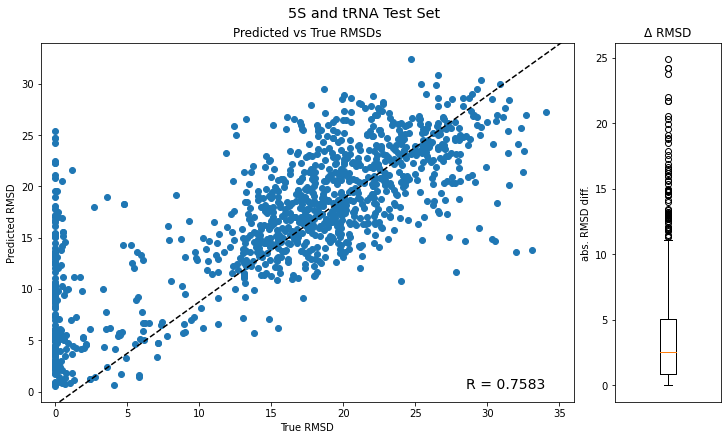

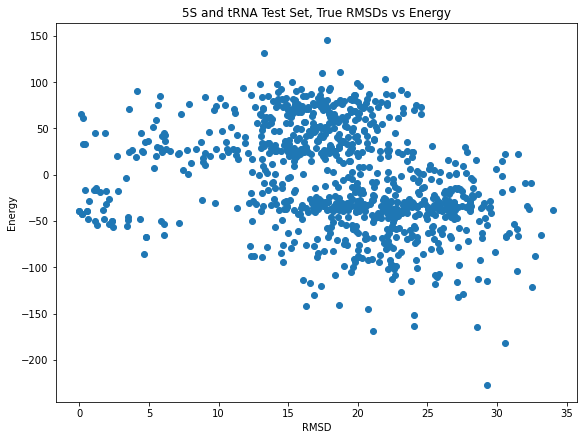

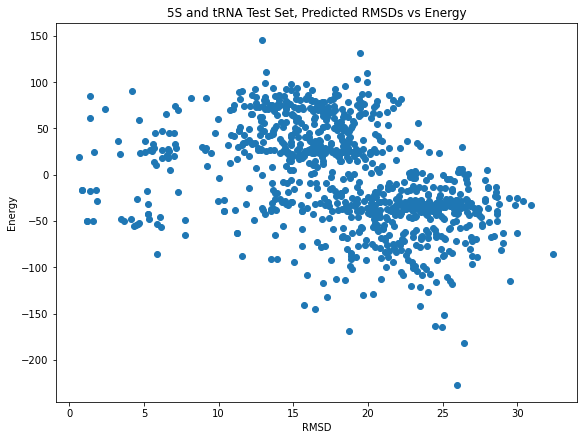

tensor([[0.]], device='cuda:0') tensor([[-0.0127]], device='cuda:0')
tensor([[0.]], device='cuda:0') tensor([[-0.0127]], device='cuda:0')
Training Set
tensor([[23.8710]], device='cuda:0') tensor([[23.8708]], device='cuda:0') 1.6763806343078613e-08
tensor([[0.]], device='cuda:0') tensor([[4.6021]], device='cuda:0') 4.102102756500244
Mean Test loss: 	 0.1958
Std. Dev. of Test loss:  0.3462
Min loss: 		 0.0000
First Quantile: 	 0.0145
Median: 		 0.0628
Third Quantile: 	 0.2356
Max Loss: 		 4.1021
LinregressResult(slope=1.0390302615253668, intercept=-0.4322604501218734, rvalue=0.9984296563772902, pvalue=0.0, stderr=0.0021174730998939663, intercept_stderr=0.04176655188535373)


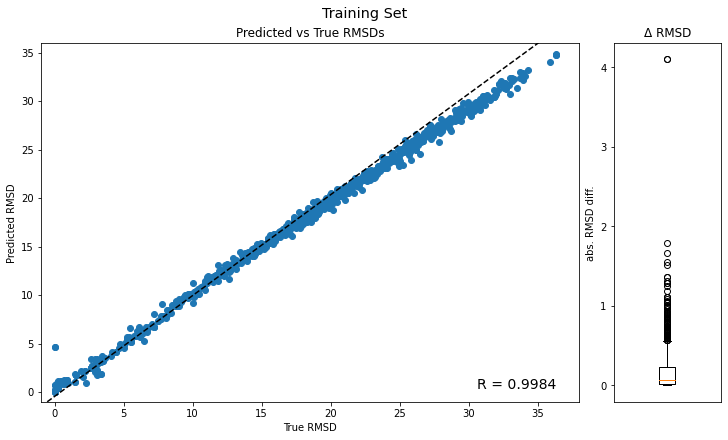

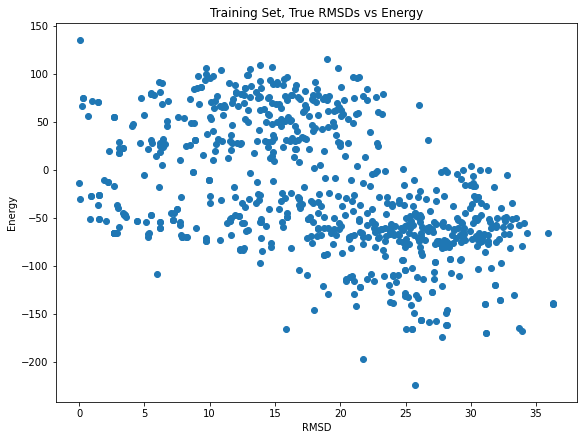

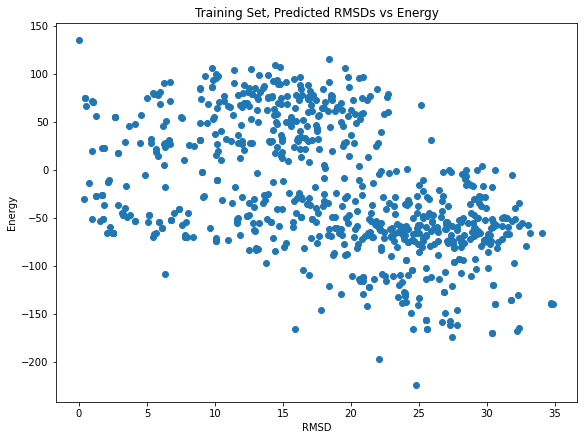

Validation Set
tensor([[14.8520]], device='cuda:0') tensor([[14.8749]], device='cuda:0') 0.00026269900263287127
tensor([[60.2560]], device='cuda:0') tensor([[12.9694]], device='cuda:0') 46.78657531738281
Mean Test loss: 	 13.8873
Std. Dev. of Test loss:  9.8938
Min loss: 		 0.0003
First Quantile: 	 4.9139
Median: 		 13.1283
Third Quantile: 	 20.1343
Max Loss: 		 46.7866
LinregressResult(slope=-0.10244427577042024, intercept=25.27254794310924, rvalue=-0.03470756142377153, pvalue=0.49101462705134, stderr=0.14861195529439947, intercept_stderr=3.0498153507152335)


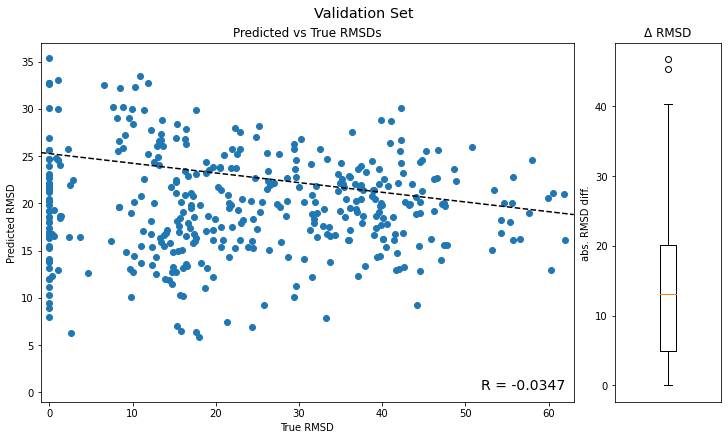

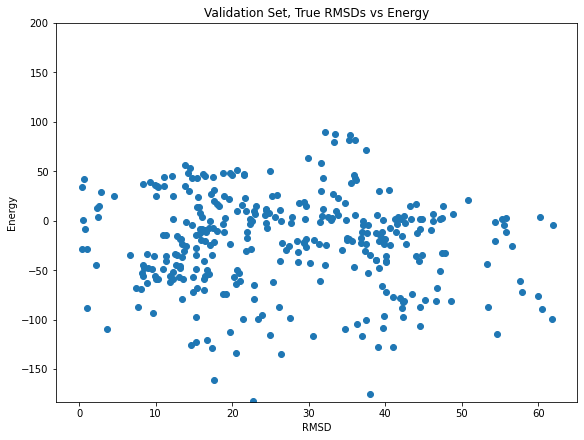

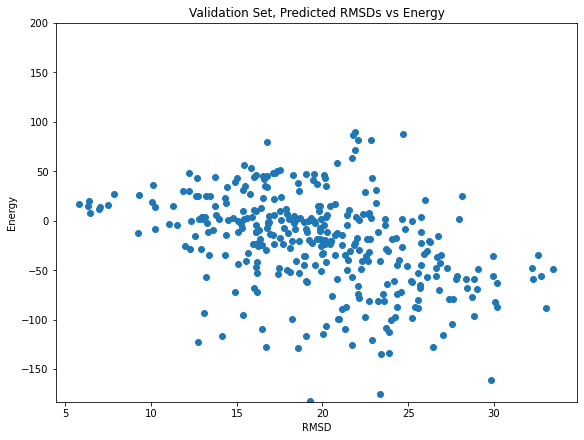

LinregressResult(slope=0.6203783058809055, intercept=9.243865489033938, rvalue=0.3412596997858556, pvalue=5.574874170713207e-42, stderr=0.044283078394789774, intercept_stderr=0.8621970089450526)


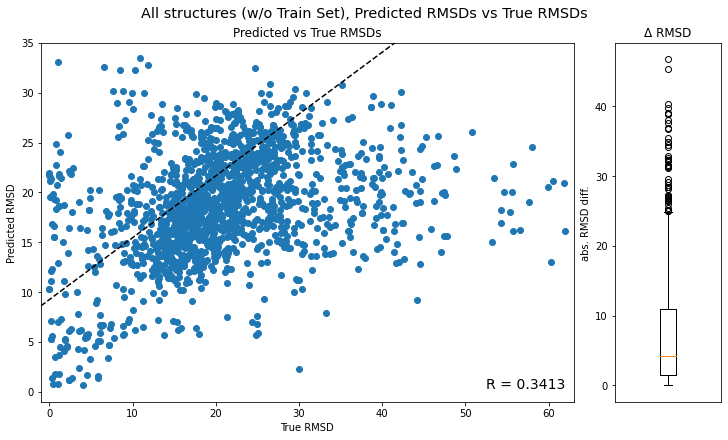

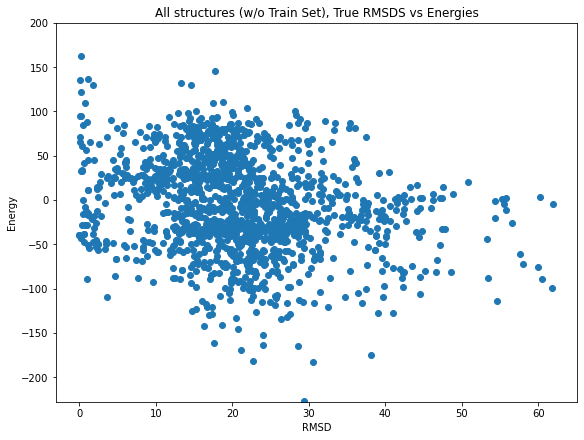

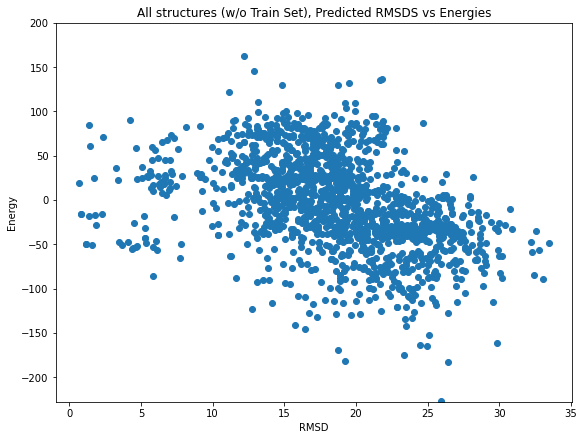

In [10]:
#Test
from pyg_classifier.utility import get_energy_dict, rmsd_scatter, e_rmsd_scatter

if "model" not in globals():
    num_node_feats = training_dataset.num_node_features
    model = DMoN_CG_Classifier(num_node_feats).to(device)

train_loader = DenseDataLoader(training_dataset, batch_size=1)
val_loader = DenseDataLoader(val_dataset, batch_size=1)
test_dataloader = DenseDataLoader(test_dataset, batch_size=1)
st_test_dataloader = DenseDataLoader(st_test_dataset, batch_size=1)

model.to(device)
model.load_state_dict(th.load(f"{run_dir}/model_data/epoch_{select}.pth"))

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
test_ls = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    en, trs, prs, tlosses = pool_test_loop(model, loader, e_dict, title, device)
    if loader != train_loader:
        energy_l += en
        true_rmsd_l += trs
        pred_rmsd_l += prs
        test_ls += tlosses

rmsd_scatter(pred_rmsd_l, true_rmsd_l, test_ls, "All structures (w/o Train Set), Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures (w/o Train Set), True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures (w/o Train Set), Predicted RMSDS vs Energies")

LinregressResult(slope=0.9641858254069473, intercept=0.6652369513415337, rvalue=0.9715930229955456, pvalue=3.781087597382066e-174, stderr=0.01416221405849563, intercept_stderr=0.2614207031202877)


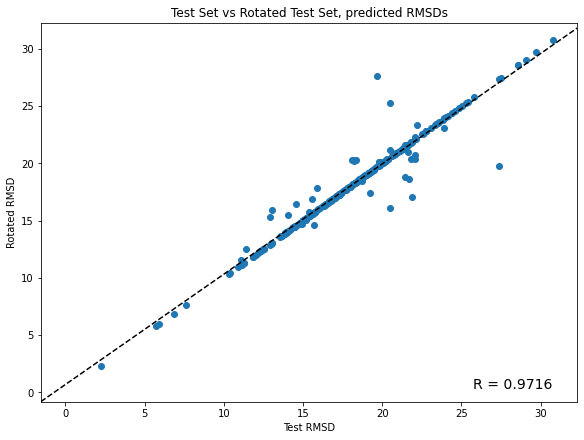

LinregressResult(slope=0.9887051110174686, intercept=0.14793789706560645, rvalue=0.9886815573926839, pvalue=1.3651339400351517e-228, stderr=0.009047320155637145, intercept_stderr=0.1175785982296425)


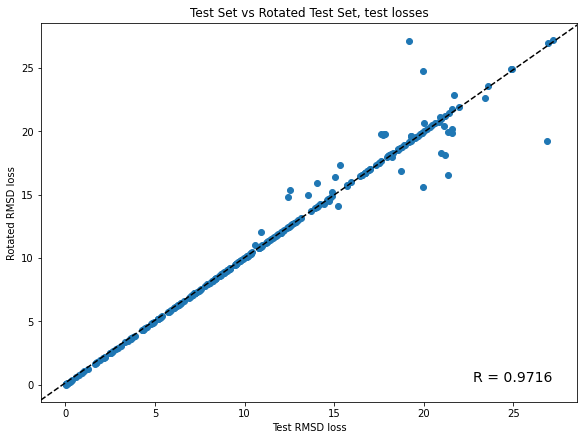

LinregressResult(slope=0.9702312517349276, intercept=0.5580388771650675, rvalue=0.9737199222989605, pvalue=0.0, stderr=0.006902150766785192, intercept_stderr=0.12690639903525475)


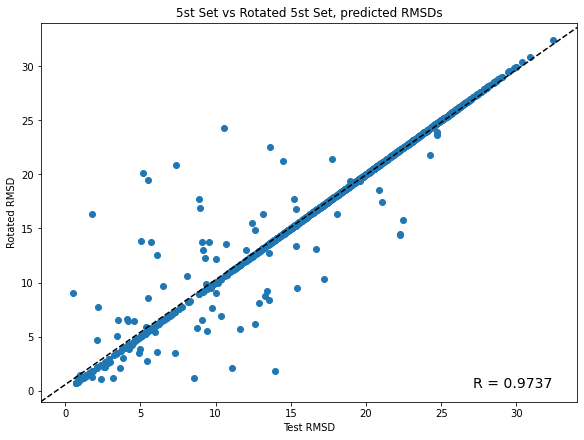

LinregressResult(slope=0.9573925876242605, intercept=0.2098035754735501, rvalue=0.9323091493751527, pvalue=0.0, stderr=0.01129589270195724, intercept_stderr=0.0632009654141437)


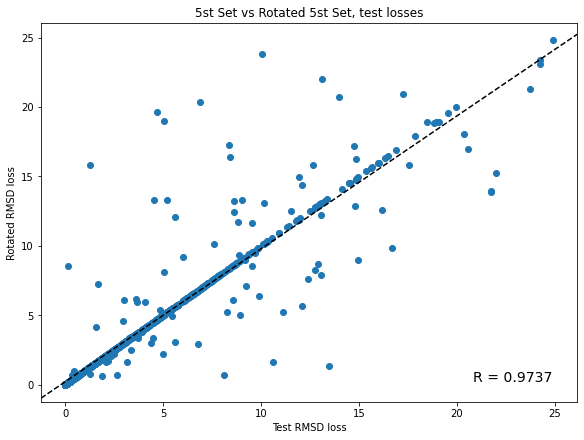

In [11]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DenseDataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DenseDataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    axs1.text(max(test_preds), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    axs2.text(max(test_ls), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")